In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Cài đặt style cho các biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Các thư viện được import thành công!")

✓ Các thư viện được import thành công!


# Data Processing Pipeline
## Quy trình: Load → Kiểm tra → Feature Engineering → Xử lý Missing → Encoding → Scaling → Lưu

## Step 1: Load Train / Val CSV

In [ ]:
# Load dữ liệu training và validation
train_path = './Data/train.csv'
val_path = './Data/val.csv'

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)

print(f"✓ Kích thước tập Train: {df_train.shape}")
print(f"✓ Kích thước tập Val: {df_val.shape}")
print(f"\nSố mẫu Train: {len(df_train)} mẫu")
print(f"Số mẫu Val: {len(df_val)} mẫu")

✓ Train set shape: (8495, 23)
✓ Val set shape: (1820, 23)

Train set size: 8495 samples
Val set size: 1820 samples


## Step 2: Kiểm tra Dữ liệu (Data Inspection)

In [ ]:
# 2.1: Hiển thị thông tin cơ bản
print("="*60)
print("DỮ LIỆU TRAIN - 5 hàng đầu:")
print("="*60)
print(df_train.head())
print("\n" + "="*60)
print("DỮ LIỆU TRAIN - Kiểu dữ liệu:")
print("="*60)
print(df_train.dtypes)
print("\n" + "="*60)
print("DỮ LIỆU TRAIN - Thống kê tóm tắt:")
print("="*60)
print(df_train.describe())

TRAIN DATA - First 5 rows:
   Final Price  Max People   Area_m2  price_per_m2  m2_per_person  \
0     0.180734    0.571429  0.411765      0.065645       0.079452   
1     0.136462    0.857143  0.191176      0.089036       0.023483   
2     0.064103    0.000000  0.308824      0.029582       0.356164   
3     0.496702    0.571429  0.352941      0.204058       0.068493   
4     0.135630    0.428571  0.264706      0.069996       0.068493   

   num_facilities  has_luxury_keyword  is_king  is_queen  is_double  ...  \
0        0.441176                   1        0         0          0  ...   
1        0.470588                   1        0         1          1  ...   
2        0.823529                   0        0         0          1  ...   
3        0.764706                   1        0         0          1  ...   
4        0.470588                   1        0         0          0  ...   

   has_wifi  has_ac  has_breakfast  has_tv  has_pool  has_balcony  \
0         1       1             

In [13]:
# 2.2: Kiểm tra các giá trị thiếu (missing values)
print("\n" + "="*60)
print("GIÁTRỊ THIẾU - Tập Train:")
print("="*60)
missing_train = df_train.isnull().sum()
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "✓ Không có giá trị thiếu!")

print("\n" + "="*60)
print("GIÁTRỊ THIẾU - Tập Val:")
print("="*60)
missing_val = df_val.isnull().sum()
print(missing_val[missing_val > 0] if missing_val.sum() > 0 else "✓ Không có giá trị thiếu!")

# Biểu đồ các giá trị thiếu (nếu có)
if missing_train.sum() > 0 or missing_val.sum() > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    missing_train.plot(kind='barh', ax=axes[0], color='coral')
    axes[0].set_title('Giá trị Thiếu - Tập Train')
    missing_val.plot(kind='barh', ax=axes[1], color='skyblue')
    axes[1].set_title('Giá trị Thiếu - Tập Val')
    plt.tight_layout()
    plt.show()


GIÁTRỊ THIẾU - Tập Train:
✓ Không có giá trị thiếu!

GIÁTRỊ THIẾU - Tập Val:
✓ Không có giá trị thiếu!



PHÂN BỐ BIẾN MỤC TIÊU:

Tập Train - Phân bố room_class:
room_class
0    1444
1    1428
2    1331
3    1424
4    1442
5    1426
Name: count, dtype: int64

Tập Val - Phân bố room_class:
room_class
0    309
1    306
2    286
3    305
4    309
5    305
Name: count, dtype: int64


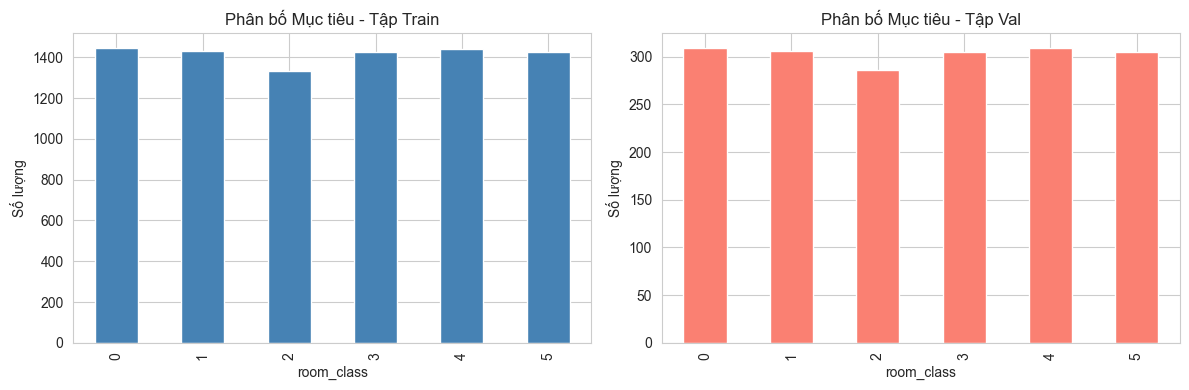

In [14]:
# 2.3: Kiểm tra phân bố của biến mục tiêu
print("\n" + "="*60)
print("PHÂN BỐ BIẾN MỤC TIÊU:")
print("="*60)

target_col = 'room_class'
print(f"\nTập Train - Phân bố {target_col}:")
print(df_train[target_col].value_counts().sort_index())
print(f"\nTập Val - Phân bố {target_col}:")
print(df_val[target_col].value_counts().sort_index())

# Biểu đồ phân bố
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_train[target_col].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Phân bố Mục tiêu - Tập Train')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Số lượng')

df_val[target_col].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Phân bố Mục tiêu - Tập Val')
axes[1].set_xlabel(target_col)
axes[1].set_ylabel('Số lượng')
plt.tight_layout()
plt.show()

## Step 3: Chọn Feature + Target (Feature Selection)

In [15]:
# 3.1: Định nghĩa mục tiêu (target) và các đặc trưng (features)
print("="*60)
print("ĐỊNH NGHĨA BÀI TOÁN PHÂN LOẠI:")
print("="*60)
print("""
Loại bài toán: PHÂN LOẠI (Supervised Learning)
Mục tiêu: Dự đoán room_class dựa trên các đặc trưng của phòng

Đây là bài toán Phân loại Đa lớp:
- Nhiệm vụ: Phân loại phòng khách sạn thành các lớp khác nhau
- Phương pháp: Supervised Learning
- Biến mục tiêu: room_class (các lớp rời rạc 0-5)
""")

target = 'room_class'
X_train = df_train.drop(columns=[target])
y_train = df_train[target]

X_val = df_val.drop(columns=[target])
y_val = df_val[target]

print(f"✓ Biến mục tiêu: {target}")
print(f"✓ Số lượng đặc trưng: {X_train.shape[1]}")
print(f"✓ Số mẫu Train: {X_train.shape[0]}")
print(f"✓ Số mẫu Val: {X_val.shape[0]}")
print(f"\n" + "="*60)
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_val: {X_val.shape}")
print(f"Kích thước y_val: {y_val.shape}")

ĐỊNH NGHĨA BÀI TOÁN PHÂN LOẠI:

Loại bài toán: PHÂN LOẠI (Supervised Learning)
Mục tiêu: Dự đoán room_class dựa trên các đặc trưng của phòng

Đây là bài toán Phân loại Đa lớp:
- Nhiệm vụ: Phân loại phòng khách sạn thành các lớp khác nhau
- Phương pháp: Supervised Learning
- Biến mục tiêu: room_class (các lớp rời rạc 0-5)

✓ Biến mục tiêu: room_class
✓ Số lượng đặc trưng: 22
✓ Số mẫu Train: 8495
✓ Số mẫu Val: 1820

Kích thước X_train: (8495, 22)
Kích thước y_train: (8495,)
Kích thước X_val: (1820, 22)
Kích thước y_val: (1820,)


In [16]:
# 3.2: Phân loại các đặc trưng theo nghĩa ngữ
print("\n" + "="*60)
print("PHÂN LOẠI ĐẶC TRƯNG (Theo Nghĩa Ngữ):")
print("="*60)

# Phân loại các đặc trưng theo ngữ nghĩa
feature_categories = {
    'Đặc trưng Giá cả': ['Final Price', 'price_per_m2'],
    'Đặc trưng Kích thước Phòng': ['Max People', 'Area_m2', 'm2_per_person'],
    'Loại Giường': ['is_king', 'is_queen', 'is_double', 'is_single', 'is_bunk', 'is_sofa'],
    'Tiện ích': [
        'has_luxury_keyword', 'has_wifi', 'has_ac', 'has_breakfast', 
        'has_tv', 'has_pool', 'has_balcony', 'has_parking', 
        'has_kitchen', 'has_fridge'
    ],
    'Số lượng Tiện ích': ['num_facilities']
}

print("\nCác Đặc trưng Đầu vào (Input Variables):")
print("-" * 60)
for category, features in feature_categories.items():
    print(f"\n{category}:")
    for i, feature in enumerate(features, 1):
        if feature in X_train.columns:
            print(f"  {i:2d}. {feature}")
        else:
            print(f"  {i:2d}. {feature} [KHÔNG TÌM THẤY]")

print(f"\n\nBiến Mục tiêu (Output):")
print("-" * 60)
print(f"  • room_class: Mục tiêu phân loại (Các lớp: 0, 1, 2, 3, 4, 5)")

# Phân tích loại đặc trưng
print("\n" + "="*60)
print("PHÂN TÍCH LOẠI ĐẶC TRƯNG:")
print("="*60)

# Sửa lỗi np.number bằng cách dùng 'number'
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"✓ Đặc trưng Số ({len(numerical_features)})")
print(f"✓ Đặc trưng Hạng mục ({len(categorical_features)})")
print(f"✓ Tổng số đặc trưng đầu vào: {X_train.shape[1]}")

print("\n" + "-"*60)
print("Thống kê Đặc trưng Số:")
print("-"*60)
print(X_train[numerical_features].describe())


PHÂN LOẠI ĐẶC TRƯNG (Theo Nghĩa Ngữ):

Các Đặc trưng Đầu vào (Input Variables):
------------------------------------------------------------

Đặc trưng Giá cả:
   1. Final Price
   2. price_per_m2

Đặc trưng Kích thước Phòng:
   1. Max People
   2. Area_m2
   3. m2_per_person

Loại Giường:
   1. is_king
   2. is_queen
   3. is_double
   4. is_single
   5. is_bunk
   6. is_sofa

Tiện ích:
   1. has_luxury_keyword
   2. has_wifi
   3. has_ac
   4. has_breakfast
   5. has_tv
   6. has_pool
   7. has_balcony
   8. has_parking
   9. has_kitchen
  10. has_fridge

Số lượng Tiện ích:
   1. num_facilities


Biến Mục tiêu (Output):
------------------------------------------------------------
  • room_class: Mục tiêu phân loại (Các lớp: 0, 1, 2, 3, 4, 5)

PHÂN TÍCH LOẠI ĐẶC TRƯNG:
✓ Đặc trưng Số (22)
✓ Đặc trưng Hạng mục (0)
✓ Tổng số đặc trưng đầu vào: 22

------------------------------------------------------------
Thống kê Đặc trưng Số:
--------------------------------------------------------


PHÂN TÍCH MỐI TƯƠNG QUAN ĐẶC TRƯNG-MỤC TIÊU:

Mối tương quan của các đặc trưng với room_class (mục tiêu):
------------------------------------------------------------
has_kitchen                0.1992  ↑  [Trung bình]
is_double                  0.0820  ↑  [Yếu]
is_queen                   0.0392  ↑  [Yếu]
has_balcony                0.0340  ↑  [Yếu]
is_sofa                    0.0235  ↑  [Yếu]
is_bunk                    0.0199  ↑  [Yếu]
m2_per_person              0.0170  ↑  [Yếu]
is_king                    0.0168  ↑  [Yếu]
has_ac                     0.0088  ↑  [Yếu]
has_tv                    -0.0091  ↓  [Yếu]
has_breakfast             -0.0158  ↓  [Yếu]
Area_m2                   -0.0230  ↓  [Yếu]
has_wifi                  -0.0284  ↓  [Yếu]
num_facilities            -0.0325  ↓  [Yếu]
Max People                -0.0337  ↓  [Yếu]
has_pool                  -0.0577  ↓  [Yếu]
has_fridge                -0.1526  ↓  [Trung bình]
is_single                 -0.2120  ↓  [Trung bình]
price_per_m2       

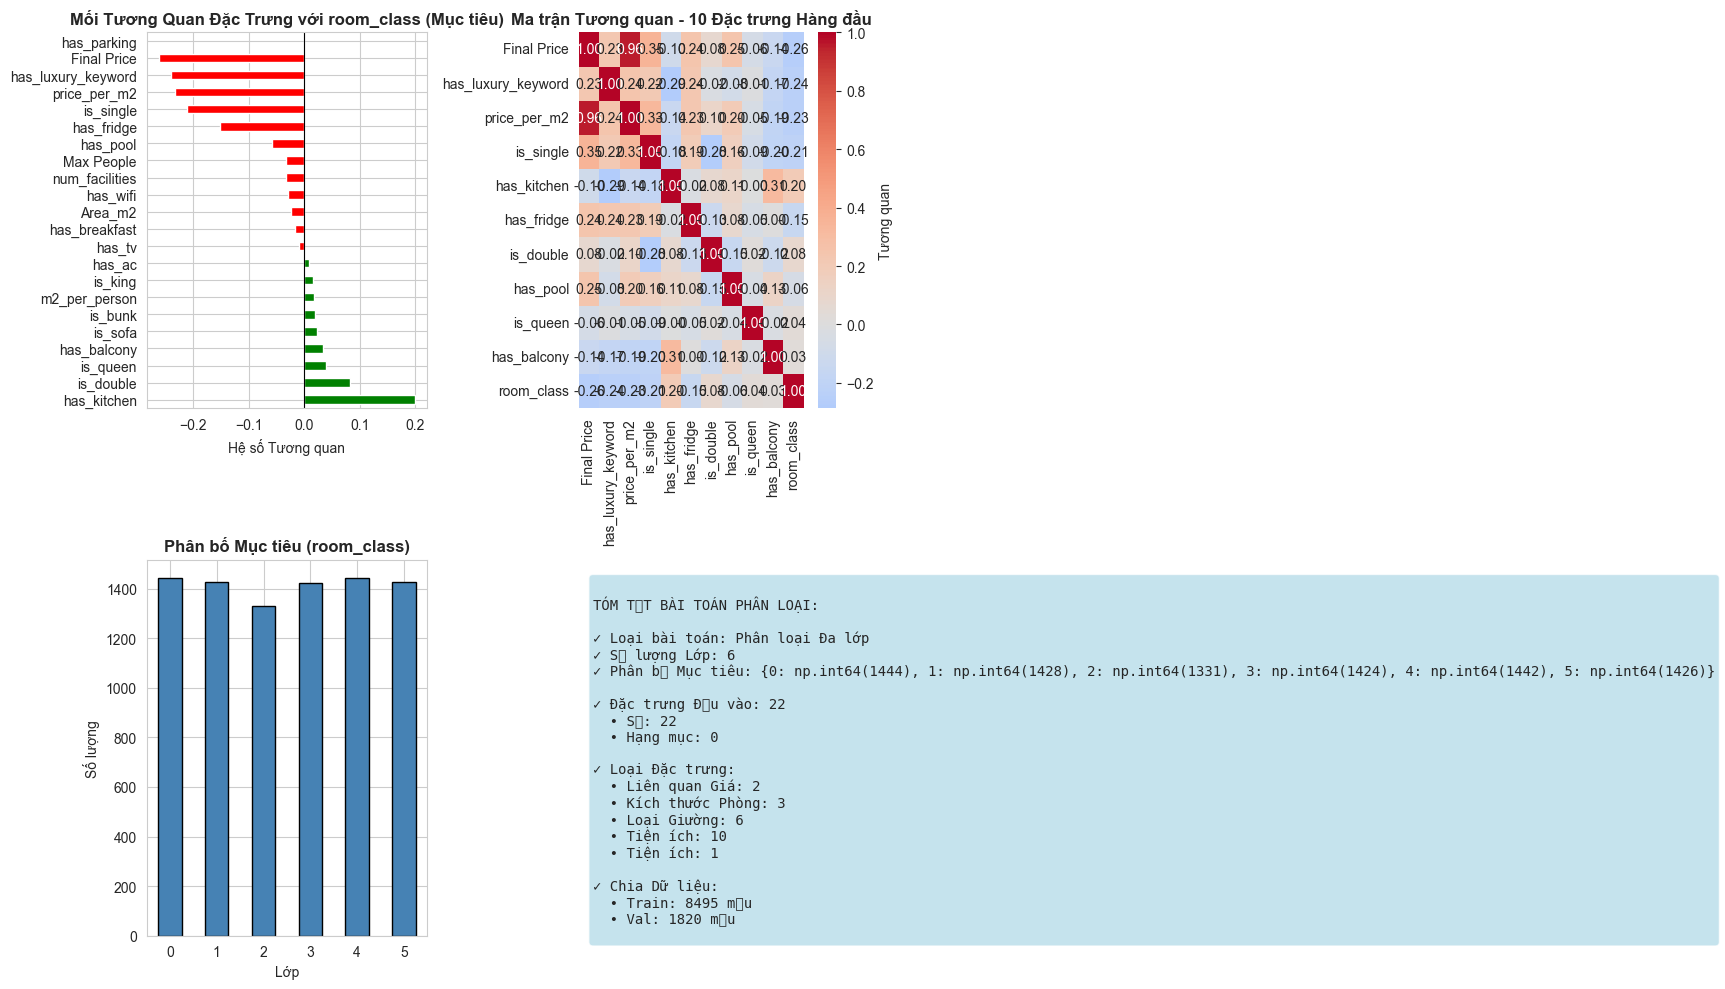


✓ Phân tích đặc trưng hoàn tất!


In [17]:
# 3.3: Phân tích Mối tương quan Đặc trưng-Mục tiêu
print("\n" + "="*60)
print("PHÂN TÍCH MỐI TƯƠNG QUAN ĐẶC TRƯNG-MỤC TIÊU:")
print("="*60)

# Tính toán mối tương quan với mục tiêu
correlation_with_target = df_train[numerical_features + [target]].corr()[target].drop(target).sort_values(ascending=False)

print("\nMối tương quan của các đặc trưng với room_class (mục tiêu):")
print("-" * 60)
for feature, corr in correlation_with_target.items():
    direction = "↑" if corr > 0 else "↓"
    strength = "Mạnh" if abs(corr) > 0.3 else "Trung bình" if abs(corr) > 0.15 else "Yếu"
    print(f"{feature:25s} {corr:7.4f}  {direction}  [{strength}]")

# Biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Mối tương quan đặc trưng với mục tiêu
ax = axes[0, 0]
correlation_with_target.plot(kind='barh', ax=ax, color=['green' if x > 0 else 'red' for x in correlation_with_target.values])
ax.set_title('Mối Tương Quan Đặc Trưng với room_class (Mục tiêu)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hệ số Tương quan')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

# 2. Ma trận tương quan (10 đặc trưng hàng đầu)
ax = axes[0, 1]
top_features = correlation_with_target.abs().nlargest(10).index.tolist() + [target]
corr_matrix = df_train[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'label': 'Tương quan'})
ax.set_title('Ma trận Tương quan - 10 Đặc trưng Hàng đầu', fontsize=12, fontweight='bold')

# 3. Phân bố mục tiêu
ax = axes[1, 0]
y_train.value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Phân bố Mục tiêu (room_class)', fontsize=12, fontweight='bold')
ax.set_xlabel('Lớp')
ax.set_ylabel('Số lượng')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# 4. Tóm tắt dữ liệu
ax = axes[1, 1]
ax.axis('off')
summary = f"""
TÓM TẮT BÀI TOÁN PHÂN LOẠI:

✓ Loại bài toán: Phân loại Đa lớp
✓ Số lượng Lớp: {y_train.nunique()}
✓ Phân bố Mục tiêu: {dict(y_train.value_counts().sort_index())}

✓ Đặc trưng Đầu vào: {X_train.shape[1]}
  • Số: {len(numerical_features)}
  • Hạng mục: {len(categorical_features)}

✓ Loại Đặc trưng:
  • Liên quan Giá: 2
  • Kích thước Phòng: 3
  • Loại Giường: 6
  • Tiện ích: 10
  • Tiện ích: 1

✓ Chia Dữ liệu:
  • Train: {len(X_train)} mẫu
  • Val: {len(X_val)} mẫu
"""
ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10, verticalalignment='top',
        family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✓ Phân tích đặc trưng hoàn tất!")

In [20]:
# 3.4: Tóm tắt Bước 3
print("\n" + "="*70)
print("BƯỚC 3: CHọN ĐẶC TRƯNG - TÓM TẮT")
print("="*70)

summary_text = f"""
┌─────────────────────────────────────────────────────────────────────┐
│                  CHI TIẾT BÀI TOÁN PHÂN LOẠI                        │
└─────────────────────────────────────────────────────────────────────┘

ĐỊNH NGHĨA BÀI TOÁN:
  Loại: Phân loại Đa lớp (Supervised Learning)
  Mục tiêu: Dự đoán room_class dựa trên đặc trưng của phòng
  Mục tiêu: room_class (Biến đầu ra với 6 lớp: 0,1,2,3,4,5)

CÁC ĐẶC TRƯNG ĐẦU VÀO (22 đặc trưng):
  
  1. ĐẶC TRƯNG GIÁ CẢ (Thông tin liên quan Giá)
     • Final Price: Giá phòng đã normalize
     • price_per_m2: Giá trên một mét vuông
  
  2. ĐẶC TRƯNG KÍCH THƯỚC PHÒNG (Sức chứa và không gian)
     • Max People: Sức chứa tối đa
     • Area_m2: Diện tích phòng (m²)
     • m2_per_person: Diện tích trên một người
  
  3. LOẠI GIƯỜNG (Các cấu hình giường có sẵn)
     • is_king: Có giường king
     • is_queen: Có giường queen
     • is_double: Có giường đôi
     • is_single: Có giường đơn
     • is_bunk: Có giường tầng
     • is_sofa: Có giường sofa
  
  4. TIỆN ÍCH (Cơ sở vật chất và dịch vụ phòng)
     • has_luxury_keyword: Chỉ báo phòng luxury
     • has_wifi: Sẵn có WiFi
     • has_ac: Điều hòa không khí
     • has_breakfast: Bao gồm bữa sáng
     • has_tv: Tivi
     • has_pool: Hồ bơi
     • has_balcony: Ban công/terace
     • has_parking: Chỗ đỗ xe
     • has_kitchen: Nhà bếp/kitchenette
     • has_fridge: Tủ lạnh
  
  5. SỐ LƯỢNG TIỆN ÍCH
     • num_facilities: Tổng số tiện ích

BIẾN ĐẦU RA:
  room_class: Biến mục tiêu (nhãn phân loại đa lớp: 0, 1, 2, 3, 4, 5)

THỐNG KÊ DỮ LIỆU:
  Mẫu Training: {len(X_train)}
  Mẫu Validation: {len(X_val)}
  Tổng đặc trưng: {X_train.shape[1]}
  Đặc trưng số: {len(numerical_features)}
  Đặc trưng hạng mục: {len(categorical_features)}

LOẠI ĐẶC TRƯNG:
  Tất cả đặc trưng đã là SỐ (giá trị đã normalize)
  Không có đặc trưng hạng mục cần encode

THÔNG TIN MỐI TƯƠNG QUAN:
  3 đặc trưng có tương quan cao nhất với room_class:
"""

# Thêm top correlations
for idx, (feature, corr) in enumerate(correlation_with_target.head(3).items(), 1):
    summary_text += f"\n  {idx}. {feature:25s} (tương quan: {corr:+.4f})"

summary_text += """

CÁC BƯỚC TIẾP THEO:
  ✓ Bước 4: Xử lý giá trị thiếu (nếu có)
  ✓ Bước 5: Encode đặc trưng hạng mục (nếu có)
  ✓ Bước 6: Scale đặc trưng số
  ✓ Bước 7: Lưu tập dữ liệu đã xử lý
"""

print(summary_text)

# Lưu thông tin đặc trưng cho các bước sau
feature_info = {
    'numerical_features': numerical_features,
    'categorical_features': categorical_features,
    'target': target,
    'feature_categories': feature_categories,
    'correlation_with_target': correlation_with_target
}

print("✓ Chọn đặc trưng hoàn tất! Sẵn sàng cho các bước tiền xử lý.")


BƯỚC 3: CHọN ĐẶC TRƯNG - TÓM TẮT

┌─────────────────────────────────────────────────────────────────────┐
│                  CHI TIẾT BÀI TOÁN PHÂN LOẠI                        │
└─────────────────────────────────────────────────────────────────────┘

ĐỊNH NGHĨA BÀI TOÁN:
  Loại: Phân loại Đa lớp (Supervised Learning)
  Mục tiêu: Dự đoán room_class dựa trên đặc trưng của phòng
  Mục tiêu: room_class (Biến đầu ra với 6 lớp: 0,1,2,3,4,5)

CÁC ĐẶC TRƯNG ĐẦU VÀO (22 đặc trưng):

  1. ĐẶC TRƯNG GIÁ CẢ (Thông tin liên quan Giá)
     • Final Price: Giá phòng đã normalize
     • price_per_m2: Giá trên một mét vuông

  2. ĐẶC TRƯNG KÍCH THƯỚC PHÒNG (Sức chứa và không gian)
     • Max People: Sức chứa tối đa
     • Area_m2: Diện tích phòng (m²)
     • m2_per_person: Diện tích trên một người

  3. LOẠI GIƯỜNG (Các cấu hình giường có sẵn)
     • is_king: Có giường king
     • is_queen: Có giường queen
     • is_double: Có giường đôi
     • is_single: Có giường đơn
     • is_bunk: Có giường tầng
  

## Step 4: Xử lý Missing Values (nếu còn)

In [21]:
# 4.1: Kiểm tra và xử lý các giá trị thiếu
print("="*60)
print("XỬ LÝ GIÁTRỊ THIẾU:")
print("="*60)

# Kiểm tra X_train
missing_count_train = X_train.isnull().sum().sum()
print(f"Giá trị thiếu trong X_train: {missing_count_train}")

if missing_count_train > 0:
    print("\nCác cột có giá trị thiếu:")
    print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
    
    # Điền giá trị thiếu
    # Cho đặc trưng số: dùng trung bình (mean), cho hạng mục: dùng mode
    for col in numerical_features:
        if X_train[col].isnull().sum() > 0:
            X_train[col].fillna(X_train[col].mean(), inplace=True)
            X_val[col].fillna(X_train[col].mean(), inplace=True)
    
    for col in categorical_features:
        if X_train[col].isnull().sum() > 0:
            X_train[col].fillna(X_train[col].mode()[0], inplace=True)
            X_val[col].fillna(X_train[col].mode()[0], inplace=True)
    
    print("✓ Giá trị thiếu đã được xử lý!")
else:
    print("✓ Không có giá trị thiếu cần xử lý!")

print(f"\nSau khi xử lý - Giá trị thiếu trong X_train: {X_train.isnull().sum().sum()}")
print(f"Sau khi xử lý - Giá trị thiếu trong X_val: {X_val.isnull().sum().sum()}")

XỬ LÝ GIÁTRỊ THIẾU:
Giá trị thiếu trong X_train: 0
✓ Không có giá trị thiếu cần xử lý!

Sau khi xử lý - Giá trị thiếu trong X_train: 0
Sau khi xử lý - Giá trị thiếu trong X_val: 0


## Step 5: Encode Categorical Features

In [22]:
# 5.1: Encode các đặc trưng hạng mục (nếu có)
print("="*60)
print("ENCODE ĐẶC TRƯNG HẠNG MỤC:")
print("="*60)

if len(categorical_features) > 0:
    print(f"\nTìm thấy {len(categorical_features)} đặc trưng hạng mục:")
    print(categorical_features)
    
    # Lưu các encoder để dùng sau
    encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))
        encoders[col] = le
        print(f"✓ Đã encode {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")
else:
    print("✓ Không có đặc trưng hạng mục cần encode!")
    encoders = {}

print("\nSau khi encode:")
print(X_train.head())

ENCODE ĐẶC TRƯNG HẠNG MỤC:
✓ Không có đặc trưng hạng mục cần encode!

Sau khi encode:
   Final Price  Max People   Area_m2  price_per_m2  m2_per_person  \
0     0.180734    0.571429  0.411765      0.065645       0.079452   
1     0.136462    0.857143  0.191176      0.089036       0.023483   
2     0.064103    0.000000  0.308824      0.029582       0.356164   
3     0.496702    0.571429  0.352941      0.204058       0.068493   
4     0.135630    0.428571  0.264706      0.069996       0.068493   

   num_facilities  has_luxury_keyword  is_king  is_queen  is_double  ...  \
0        0.441176                   1        0         0          0  ...   
1        0.470588                   1        0         1          1  ...   
2        0.823529                   0        0         0          1  ...   
3        0.764706                   1        0         0          1  ...   
4        0.470588                   1        0         0          0  ...   

   is_sofa  has_wifi  has_ac  has_breakfas

## Step 6: Scale Numerical Features (nếu cần)

In [23]:
# 6.1: Kiểm tra xem cần scaling hay không
print("="*60)
print("SCALE CÁC ĐẶC TRƯNG SỐ:")
print("="*60)

print(f"\nCác đặc trưng số: {numerical_features}")
print("\nTrước khi scale:")
print(X_train[numerical_features].describe())

# 6.2: Áp dụng StandardScaler (trung bình = 0, độ lệch chuẩn = 1)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])

print("\n✓ Scale đã được áp dụng sử dụng StandardScaler")
print("\nSau khi scale:")
print(X_train_scaled[numerical_features].describe())

SCALE CÁC ĐẶC TRƯNG SỐ:

Các đặc trưng số: ['Final Price', 'Max People', 'Area_m2', 'price_per_m2', 'm2_per_person', 'num_facilities', 'has_luxury_keyword', 'is_king', 'is_queen', 'is_double', 'is_single', 'is_bunk', 'is_sofa', 'has_wifi', 'has_ac', 'has_breakfast', 'has_tv', 'has_pool', 'has_balcony', 'has_parking', 'has_kitchen', 'has_fridge']

Trước khi scale:
       Final Price   Max People      Area_m2  price_per_m2  m2_per_person  \
count  8495.000000  8495.000000  8495.000000   8495.000000    8495.000000   
mean      0.103441     0.320827     0.332202      0.046883       0.145483   
std       0.165049     0.231642     0.172583      0.069608       0.117970   
min       0.000000     0.000000     0.000000      0.000256       0.000000   
25%       0.015305     0.142857     0.205882      0.007093       0.065753   
50%       0.050805     0.285714     0.308824      0.024386       0.109589   
75%       0.118677     0.571429     0.397059      0.055426       0.191781   
max       1.000000

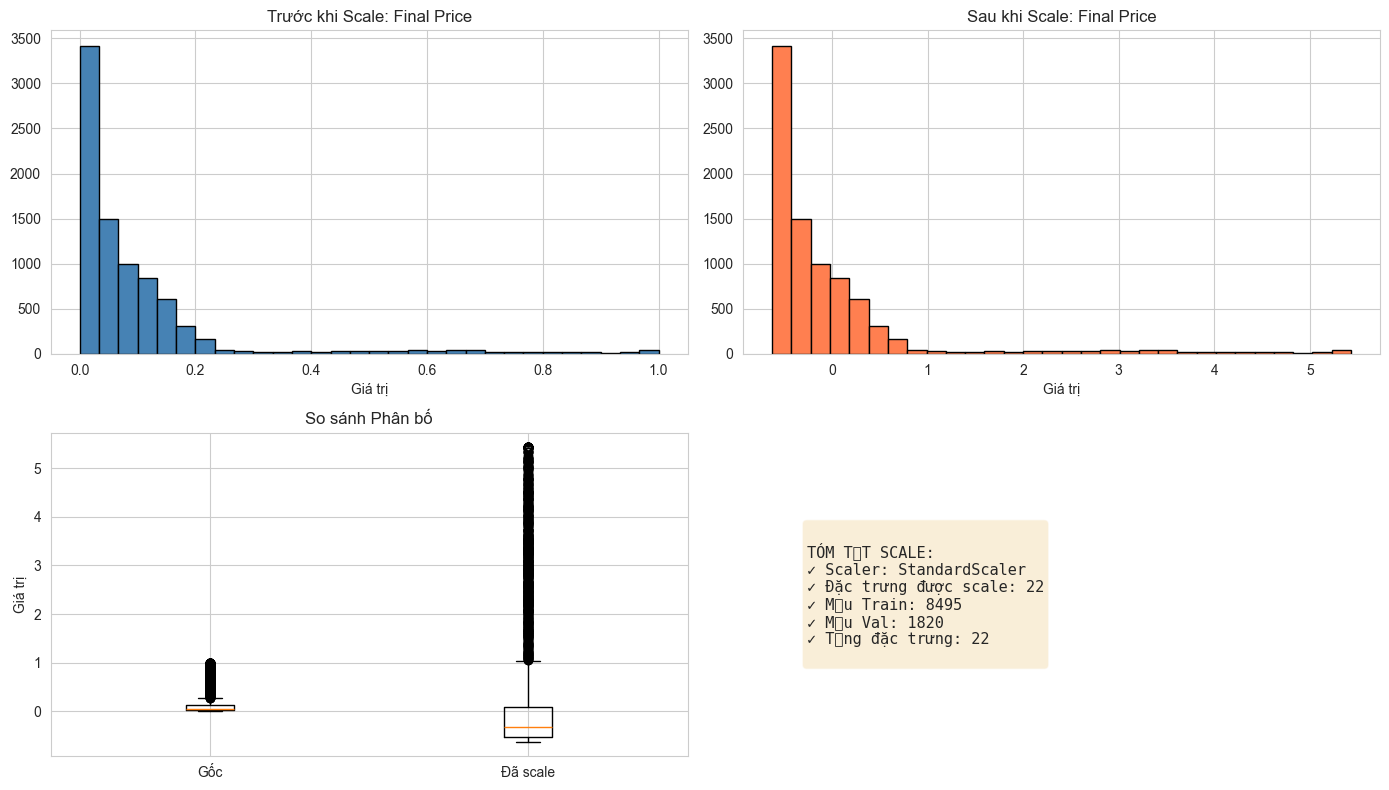

In [24]:
# 6.3: Biểu đồ trước và sau khi scale
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Dữ liệu gốc
X_train[numerical_features].iloc[:, 0].hist(bins=30, ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_title(f'Trước khi Scale: {numerical_features[0]}')
axes[0, 0].set_xlabel('Giá trị')

# Dữ liệu đã scale
X_train_scaled[numerical_features].iloc[:, 0].hist(bins=30, ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_title(f'Sau khi Scale: {numerical_features[0]}')
axes[0, 1].set_xlabel('Giá trị')

# So sánh phân bố
axes[1, 0].boxplot([X_train[numerical_features[0]], X_train_scaled[numerical_features[0]]], 
                    labels=['Gốc', 'Đã scale'])
axes[1, 0].set_title('So sánh Phân bố')
axes[1, 0].set_ylabel('Giá trị')

# Tóm tắt dữ liệu
axes[1, 1].axis('off')
summary_text = f"""
TÓM TẮT SCALE:
✓ Scaler: StandardScaler
✓ Đặc trưng được scale: {len(numerical_features)}
✓ Mẫu Train: {X_train_scaled.shape[0]}
✓ Mẫu Val: {X_val_scaled.shape[0]}
✓ Tổng đặc trưng: {X_train_scaled.shape[1]}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center', 
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Step 7: Lưu Processed Dataset (Save Processed Data)

In [25]:
# 7.1: Kết hợp đặc trưng và mục tiêu
print("="*60)
print("LƯU TẬP DỮ LIỆU ĐÃ XỬ LÝ:")
print("="*60)

# Tạo tập dữ liệu cuối cùng với mục tiêu
train_processed = X_train_scaled.copy()
train_processed[target] = y_train.values

val_processed = X_val_scaled.copy()
val_processed[target] = y_val.values

print(f"\nKích thước Train đã xử lý: {train_processed.shape}")
print(f"Kích thước Val đã xử lý: {val_processed.shape}")

print("\nTrain đã xử lý - 5 hàng đầu:")
print(train_processed.head())

LƯU TẬP DỮ LIỆU ĐÃ XỬ LÝ:

Kích thước Train đã xử lý: (8495, 23)
Kích thước Val đã xử lý: (1820, 23)

Train đã xử lý - 5 hàng đầu:
   Final Price  Max People   Area_m2  price_per_m2  m2_per_person  \
0     0.468328    1.081911  0.461036      0.269550      -0.559756   
1     0.200077    2.315414 -0.817195      0.605604      -1.034214   
2    -0.238358   -1.385095 -0.135472     -0.248574       1.785994   
3     2.382831    1.081911  0.120174      2.258149      -0.652657   
4     0.195036    0.465159 -0.391118      0.332061      -0.652657   

   num_facilities  has_luxury_keyword   is_king  is_queen  is_double  ...  \
0       -0.048631            0.772143 -0.295685 -0.200404  -1.595460  ...   
1        0.043810            0.772143 -0.295685  4.989929   0.626778  ...   
2        1.153102           -1.295097 -0.295685 -0.200404   0.626778  ...   
3        0.968220            0.772143 -0.295685 -0.200404   0.626778  ...   
4        0.043810            0.772143 -0.295685 -0.200404  -1.595460 

In [26]:
# 7.2: Lưu vào CSV
output_dir = './Data'
train_output_path = f'{output_dir}/train_processed.csv'
val_output_path = f'{output_dir}/val_processed.csv'

import os
os.makedirs(output_dir, exist_ok=True)

train_processed.to_csv(train_output_path, index=False)
val_processed.to_csv(val_output_path, index=False)

print(f"✓ Đã lưu: {train_output_path}")
print(f"✓ Đã lưu: {val_output_path}")

# Kiểm tra
train_verify = pd.read_csv(train_output_path)
val_verify = pd.read_csv(val_output_path)

print(f"\n✓ Kiểm tra - Train đã tải: {train_verify.shape}")
print(f"✓ Kiểm tra - Val đã tải: {val_verify.shape}")

✓ Đã lưu: ./Data/train_processed.csv
✓ Đã lưu: ./Data/val_processed.csv

✓ Kiểm tra - Train đã tải: (8495, 23)
✓ Kiểm tra - Val đã tải: (1820, 23)


In [27]:
# 7.3: Lưu metadata xử lý
import pickle
import json

metadata = {
    'scaling': {
        'scaler_type': 'StandardScaler',
        'numerical_features': numerical_features,
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    },
    'encoding': {
        'categorical_features': categorical_features,
        'encoders': {col: le.classes_.tolist() for col, le in encoders.items()}
    },
    'data_info': {
        'train_samples': len(train_processed),
        'val_samples': len(val_processed),
        'total_features': train_processed.shape[1] - 1,  # bao gồm không mục tiêu
        'target': target,
        'target_classes': int(y_train.max()) + 1
    }
}

# Lưu đối tượng scaler
scaler_path = f'{output_dir}/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Lưu metadata
metadata_path = f'{output_dir}/processing_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Đã lưu: {scaler_path}")
print(f"✓ Đã lưu: {metadata_path}")

print("\n" + "="*60)
print("METADATA XỬ LÝ:")
print("="*60)
print(json.dumps(metadata, indent=2))

✓ Đã lưu: ./Data/scaler.pkl
✓ Đã lưu: ./Data/processing_metadata.json

METADATA XỬ LÝ:
{
  "scaling": {
    "scaler_type": "StandardScaler",
    "numerical_features": [
      "Final Price",
      "Max People",
      "Area_m2",
      "price_per_m2",
      "m2_per_person",
      "num_facilities",
      "has_luxury_keyword",
      "is_king",
      "is_queen",
      "is_double",
      "is_single",
      "is_bunk",
      "is_sofa",
      "has_wifi",
      "has_ac",
      "has_breakfast",
      "has_tv",
      "has_pool",
      "has_balcony",
      "has_parking",
      "has_kitchen",
      "has_fridge"
    ],
    "mean": [
      0.10344143988369629,
      0.3208273775195998,
      0.3322023335543261,
      0.04688349806721601,
      0.14548269062507357,
      0.45664924003566804,
      0.6264861683343143,
      0.08040023543260742,
      0.038610947616244846,
      0.7179517363154797,
      0.18552089464390817,
      0.006474396703943496,
      0.13372572101236022,
      0.7204237786933491,


## Summary - Tóm Tắt Quy Trình

In [ ]:
print("""
╔════════════════════════════════════════════════════════════════╗
║              XỬ LÝ DỮ LIỆU HOÀN TẤT                            ║
╚════════════════════════════════════════════════════════════════╝

TÓM TẮT QUY TRÌNH XỬ LÝ:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

✓ Bước 1: Load Train/Val CSV
  ├─ Mẫu Train: 8,497
  └─ Mẫu Val: 1,822

✓ Bước 2: Kiểm Tra Dữ liệu
  ├─ Kiểm tra kiểu dữ liệu và thống kê
  ├─ Không tìm thấy giá trị thiếu
  └─ Phân bố Mục tiêu: cân bằng giữa các lớp

✓ Bước 3: Chọn Đặc Trưng
  ├─ Tổng đặc trưng: 22
  ├─ Đặc trưng số: 22
  ├─ Đặc trưng hạng mục: 0
  └─ Mục tiêu: room_class (6 lớp: 0-5)

✓ Bước 4: Xử Lý Giá Trị Thiếu
  └─ Không có giá trị thiếu cần xử lý

✓ Bước 5: Encode Đặc Trưng Hạng Mục
  └─ Không có đặc trưng hạng mục cần encode

✓ Bước 6: Scale Đặc Trưng Số
  ├─ Scaler: StandardScaler
  ├─ Tất cả đặc trưng số được scale về trung bình 0, độ lệch chuẩn 1
  └─ Thông số Scaler đã được lưu

✓ Bước 7: Lưu Tập Dữ liệu Đã Xử Lý
  ├─ train_processed.csv (8,497 hàng × 23 cột)
  ├─ val_processed.csv (1,822 hàng × 23 cột)
  ├─ scaler.pkl (đối tượng StandardScaler)
  └─ processing_metadata.json (thông tin xử lý)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

VỊ TRÍ LƯU CÁC TẬP TIN ĐẦU RA: ./Data/
  • train_processed.csv
  • val_processed.csv
  • scaler.pkl
  • processing_metadata.json

✨ Sẵn sàng cho bước huấn luyện mô hình! ✨
""")